# Newton-Gauss Method for Nonlinear Optimization

In [1]:
# Data and model from: http://www.itl.nist.gov/div898/strd/nls/data/LINKS/DATA/Gauss2.dat
import pandas as pd
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from sympy import *
init_printing()
from IPython.display import display, Math
%matplotlib notebook

## The data

<IPython.core.display.Javascript object>


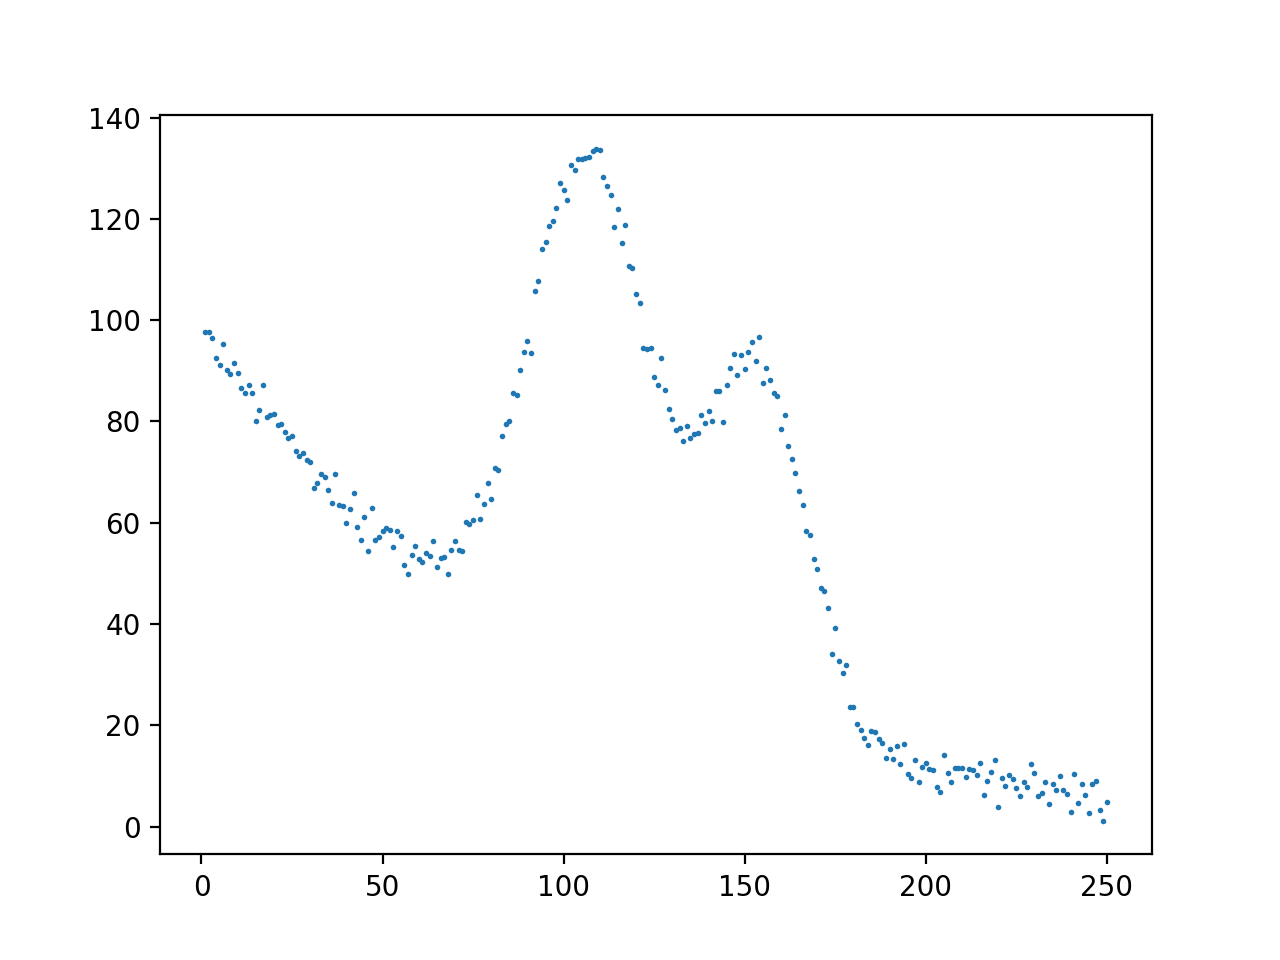

In [2]:
data = pd.read_table("data.txt", index_col=0)

plt.scatter(data.index, data.y, s=1);

## The model:
$$
    \beta_1 \exp(\beta_2x) + \beta_3 exp\left(\frac{-(x - \beta_4)^2}{{\beta_5^2}}\right) + \beta_6 exp\left(\frac{-(x - \beta_7)^2}{{\beta_8^2}}\right)
$$

In [3]:
b1, b2, b3, b4, b5, b6, b7, b8, x, y = symbols("beta1 beta2 beta3 beta4 beta5 beta6 beta7 beta8 x y")

f = lambda x, b1, b2, b3, b4, b5, b6, b7, b8: b1 * exp(b2*x) + \
                                                 b3 * exp(-(x - b4)**2 / b5 **2) + \
                                                 b6 * exp(-(x - b7)**2 / b8 **2)

gi = lambda x, y, inputs: f(x, *inputs) - y

fs = Function("f")
gis = Function("g_i")
beta_hat = Symbol("betabar")
xi, yi = symbols("x_i, y_i")

inputs = xi, b1, b2, b3, b4, b5, b6, b7, b8
betas = b1, b2, b3, b4, b5, b6, b7, b8
variables = b1, b2, b3, b4, b5, b6, b7, b8, xi, yi

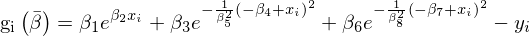

In [4]:
Eq(gis(beta_hat), gi(xi, yi, betas))

## The derivatives

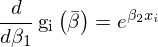

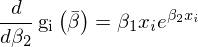

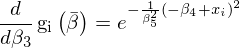

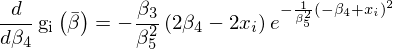

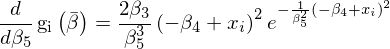

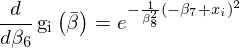

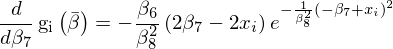

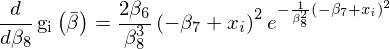

In [5]:
# Creating a list of gradients for every gi
gradient_i = []
for beta in betas:
    partial_eq = diff(gi(xi, yi, betas), beta)
    partial_func = Derivative(gis(beta_hat), beta)
    gradient_i.append(partial_eq)
    display(Eq(partial_func, partial_eq))

In [6]:
def jacobian_errors(data, beta_k, varbs, gradient_func):
    """
    Return the Jacobian and G_errors to compute
    one iteration of the Gauss-Newton method.
    :param data: The input data in which'y' is the column name to predict
    :param beta_k: a list of beta elements to pass in the model (the variables to find)
    :param varbs: list of defined sympy variables
    :param gradient_func: a list of sympy derivives of the error function to minimize
    """
    jacobian = []
    g_err = []
    for xp, yp in zip(data.index, data.y):
        # Filling Jacobian Matrix
        parmeters = []
        parmeters.extend(beta_k)
        parmeters.extend([xp, yp])
        efunc = {var: value for (var, value) in
                            zip(varbs, parmeters)}
        gradient_i_val = [grad.subs(efunc) for grad in gradient_func]
        jacobian.append(gradient_i_val)

        # Filling G_error function matrix
        g_err.append(gi(xp, yp, beta_k))


    jacobian = np.array(jacobian).astype(float)
    g_err = np.array([g_err]).astype(float).T
    
    return jacobian, g_err

In [7]:
# Starting Beta
beta_k = [96, 0.009, 103, 106, 18, 72, 151, 18]
# List of fitted curves
Y = []
X = np.linspace(1,250, 500)
for i in range(10):
    print("Iteration #{}".format(i+1))
    Y_i = [f(x, *beta_k) for x in X]
    Y.append(np.array(Y_i).astype(float))
    jacb, gerr = jacobian_errors(data, beta_k, variables, gradient_i)
    beta_k = (np.array([beta_k]).T - inv(jacb.T @ jacb) @ (jacb.T @ gerr)).ravel()

Iteration #1
Iteration #2
Iteration #3
Iteration #4
Iteration #5
Iteration #6
Iteration #7
Iteration #8
Iteration #9
Iteration #10


In [8]:
d = pd.DataFrame(Y).T
d.index = np.linspace(1, 251, 500)
d.columns = ["It_{}".format(i) for i in range(10)]
d.sort_index(axis=1, inplace=True)

<IPython.core.display.Javascript object>


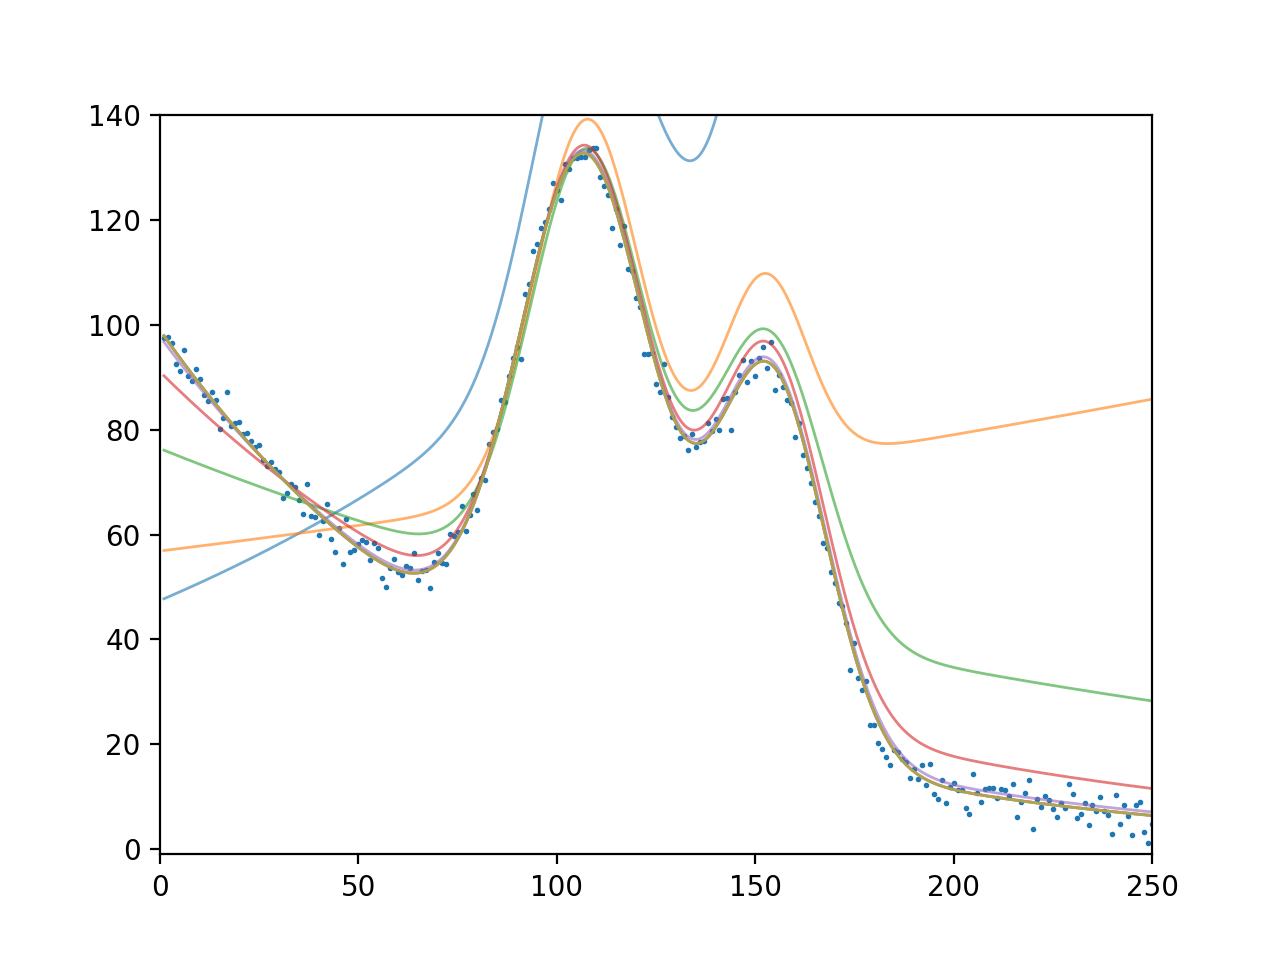

In [9]:
ax = d.drop("It_0", 1).plot(alpha=0.6, linewidth=1, legend=None)
ax.scatter(data.index, data.y, s=1)
plt.xlim(0, 250)
plt.ylim(-1, 140)

In [10]:
sum(gerr**2)

array([ 1247.52820923])

# Animating Convergence

In [11]:
title=r"$\beta_1 \exp(\beta_2x) + \beta_3 exp\left(\frac{-(x - \beta_4)^2}{{\beta_5^2}}\right) + \beta_6 exp\left(\frac{-(x - \beta_7)^2}{{\beta_8^2}}\right)$"
text_plot = "Iteration: {}"

<IPython.core.display.Javascript object>


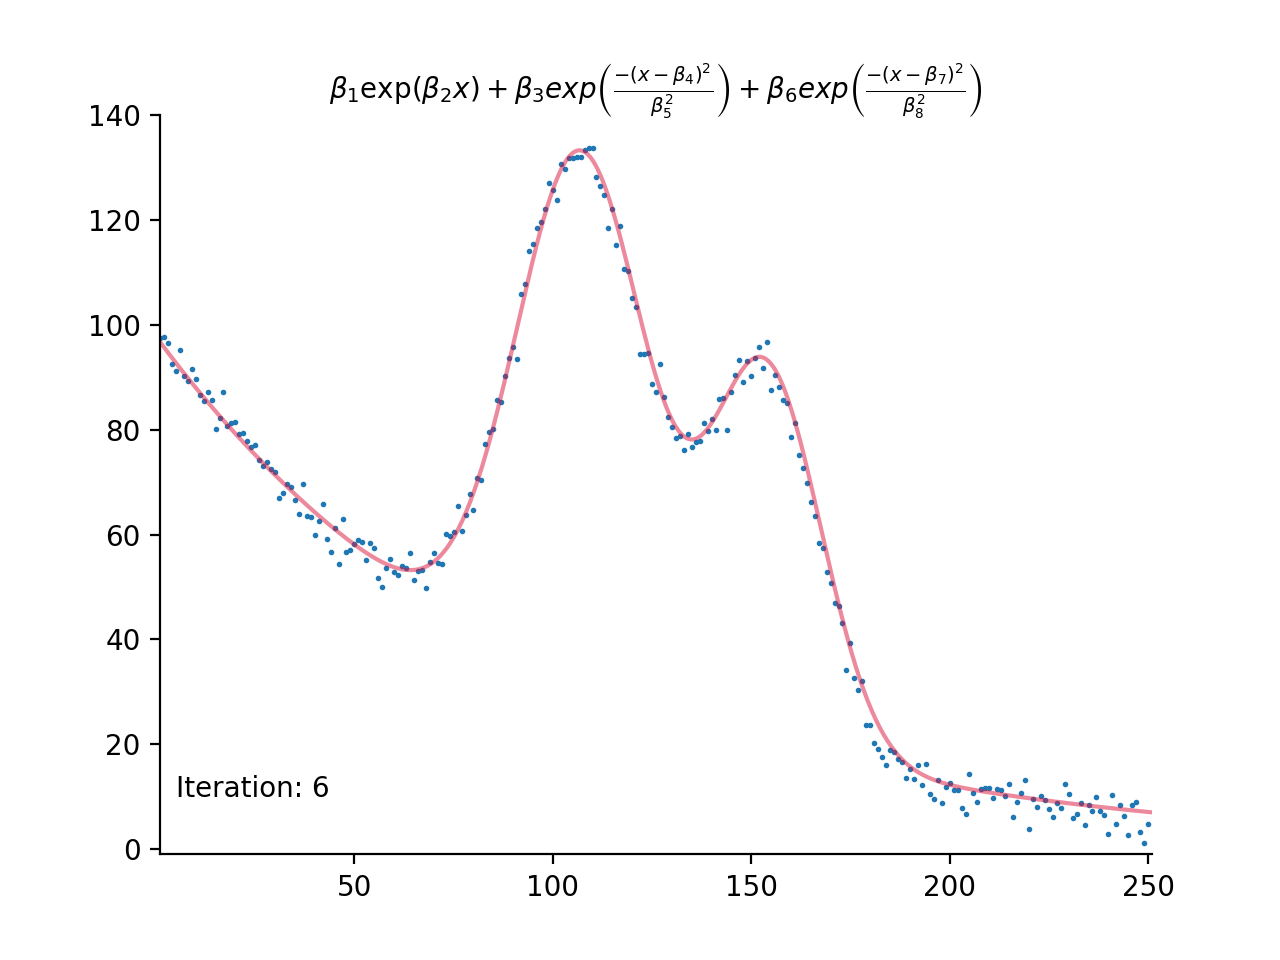

In [15]:
import matplotlib.animation as animation
fig, ax = plt.subplots()

def animate(i):
    plt.cla()
    plt.xlim(0, 250)
    plt.ylim(-1, 140)
    ax.scatter(data.index, data.y, s=1)
    ax.spines["top"].set_color("none")
    ax.spines["right"].set_color("none")
    d.iloc[:,i].plot(legend=None, color="crimson", alpha=0.5)
    plt.title(title, fontsize=10)
    

    plt.text(5, 10, text_plot.format(i+1))
    
ani = animation.FuncAnimation(fig, animate, range(10), interval=300)
#ani.save("fig.mp4", fps=3, dpi=250)